## Import Libraries

In [42]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import gym
from gym import spaces
import numpy as np
import pandas as pd
import yfinance as yf
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

In [24]:
# Define the ticker symbol for DJIA
ticker = "^DJI"

# Download historical data from Yahoo Finance
df = yf.download(ticker, start="1980-01-01", end="2023-01-01")

# Display the first few rows of the dataframe
print(df.describe())

[*********************100%%**********************]  1 of 1 completed

               Open          High           Low         Close     Adj Close  \
count   7809.000000   7809.000000   7809.000000   7809.000000   7809.000000   
mean   13603.710216  13685.909862  13518.295498  13606.634165  13606.634165   
std     8126.208027   8168.615268   8080.523208   8126.112967   8126.112967   
min     3136.600098   3172.629883   3095.790039   3136.600098   3136.600098   
25%     8635.309570   8736.070312   8540.120117   8639.190430   8639.190430   
50%    10937.940430  11006.580078  10865.419922  10939.950195  10939.950195   
75%    17277.109375  17409.720703  17163.730469  17280.830078  17280.830078   
max    36722.601562  36952.648438  36636.000000  36799.648438  36799.648438   

             Volume  
count  7.809000e+03  
mean   1.888843e+08  
std    1.306372e+08  
min    8.410000e+06  
25%    7.790000e+07  
50%    1.846000e+08  
75%    2.715000e+08  
max    9.159900e+08  


/var/folders/c_/rcydbtw12dz7bdcbj5s8j8r00000gn/T/ipykernel_4210/1740336208.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[column], ax=axes[1], shade=True)


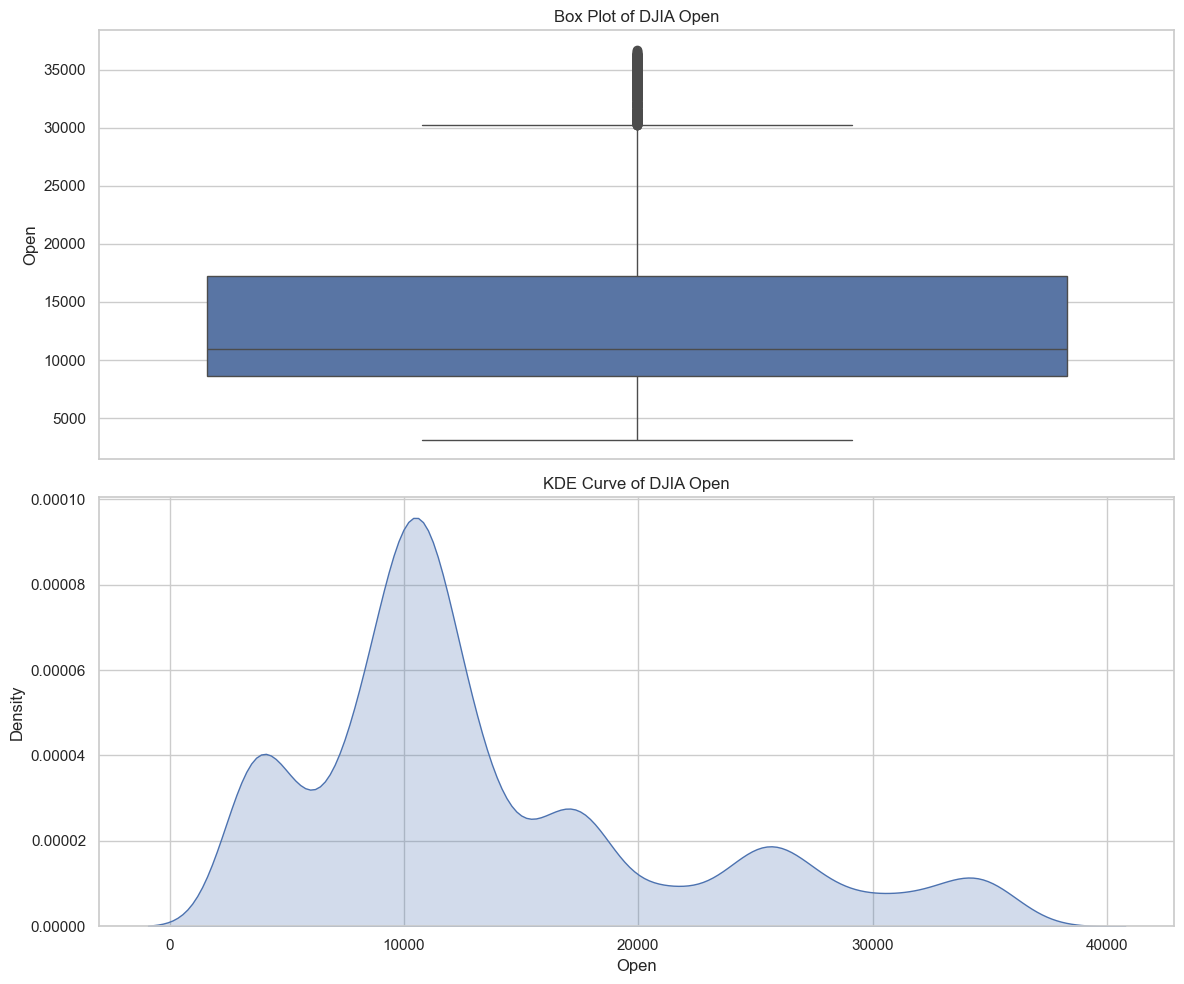

/var/folders/c_/rcydbtw12dz7bdcbj5s8j8r00000gn/T/ipykernel_4210/1740336208.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[column], ax=axes[1], shade=True)


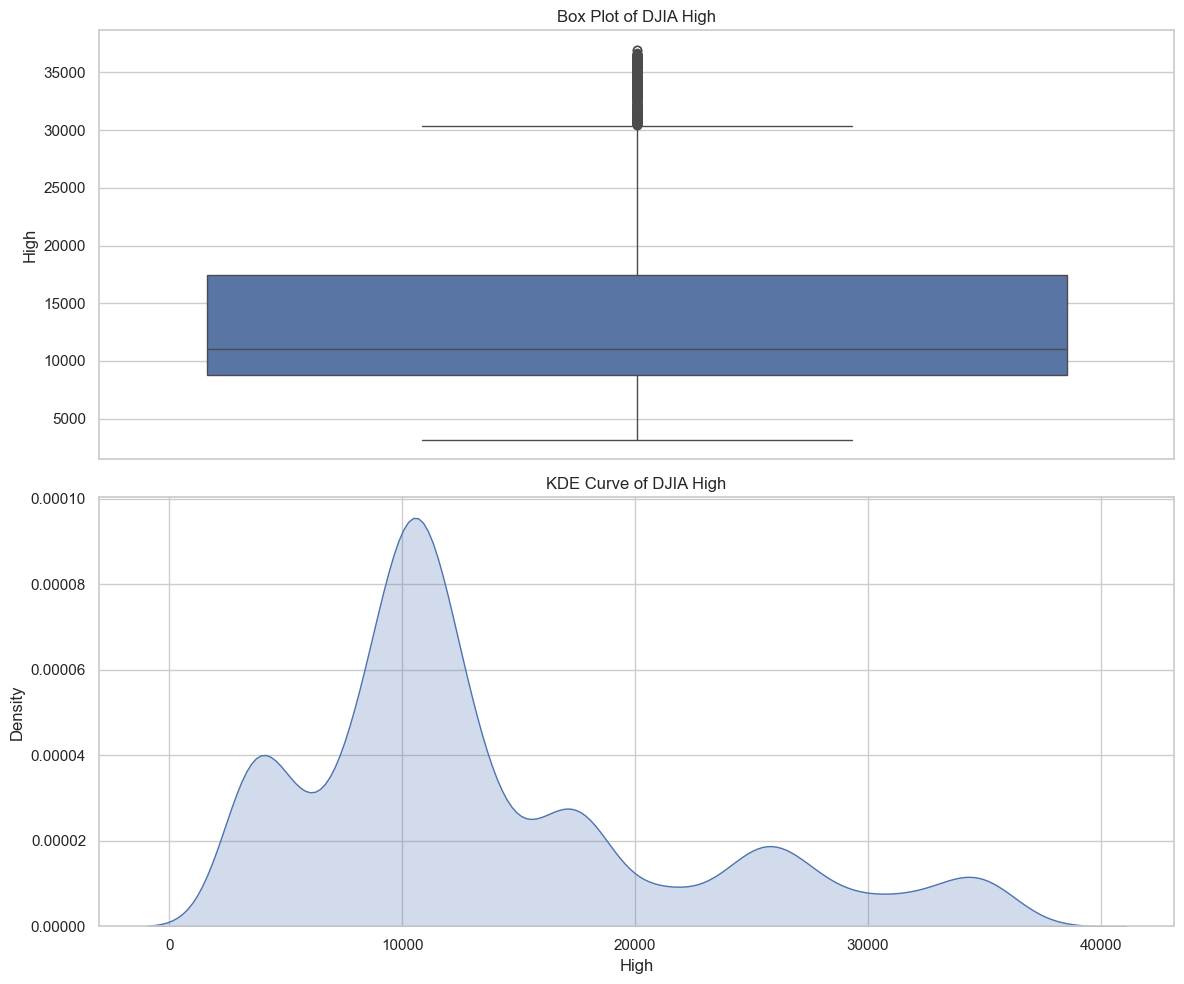

/var/folders/c_/rcydbtw12dz7bdcbj5s8j8r00000gn/T/ipykernel_4210/1740336208.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[column], ax=axes[1], shade=True)


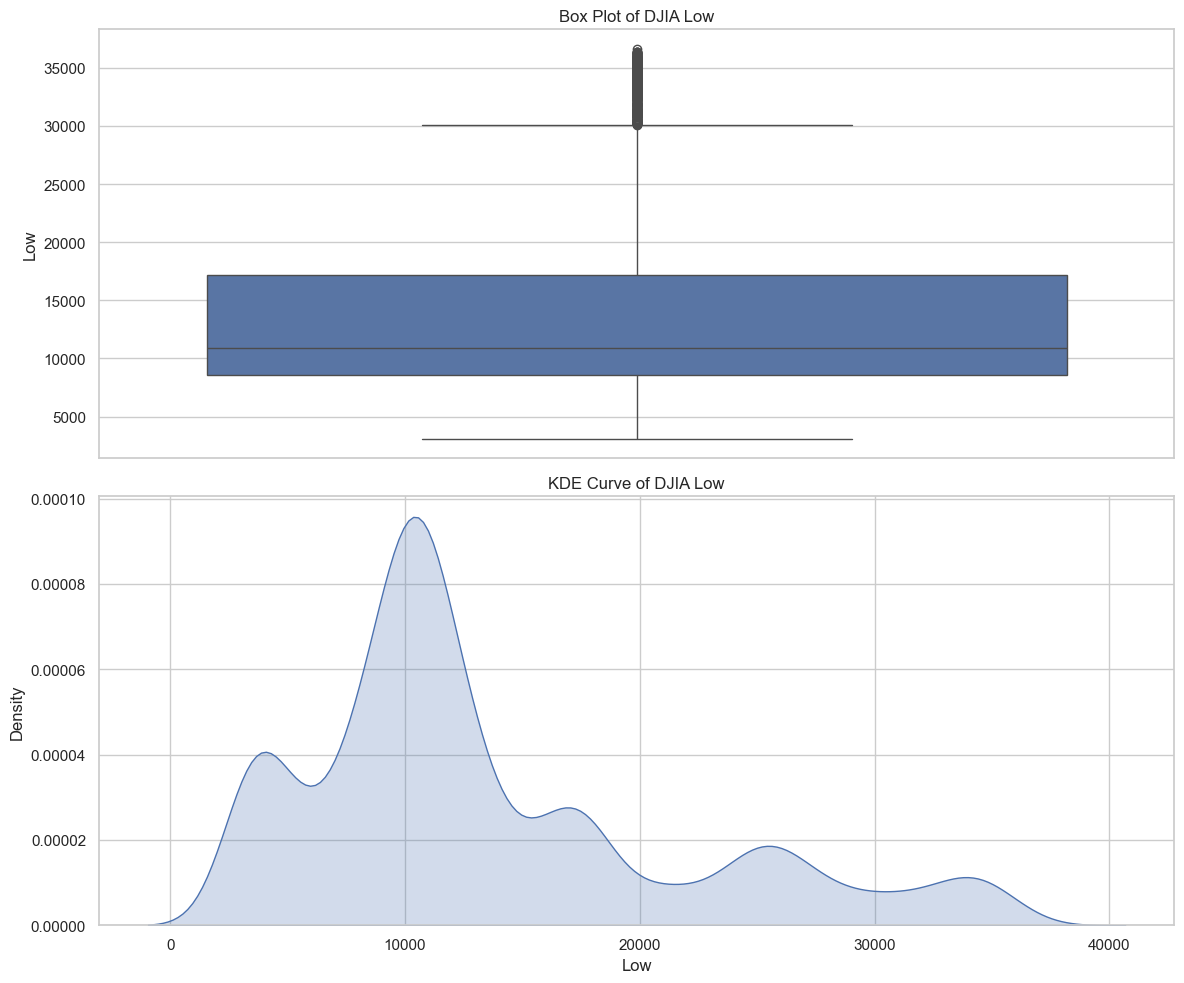

/var/folders/c_/rcydbtw12dz7bdcbj5s8j8r00000gn/T/ipykernel_4210/1740336208.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[column], ax=axes[1], shade=True)


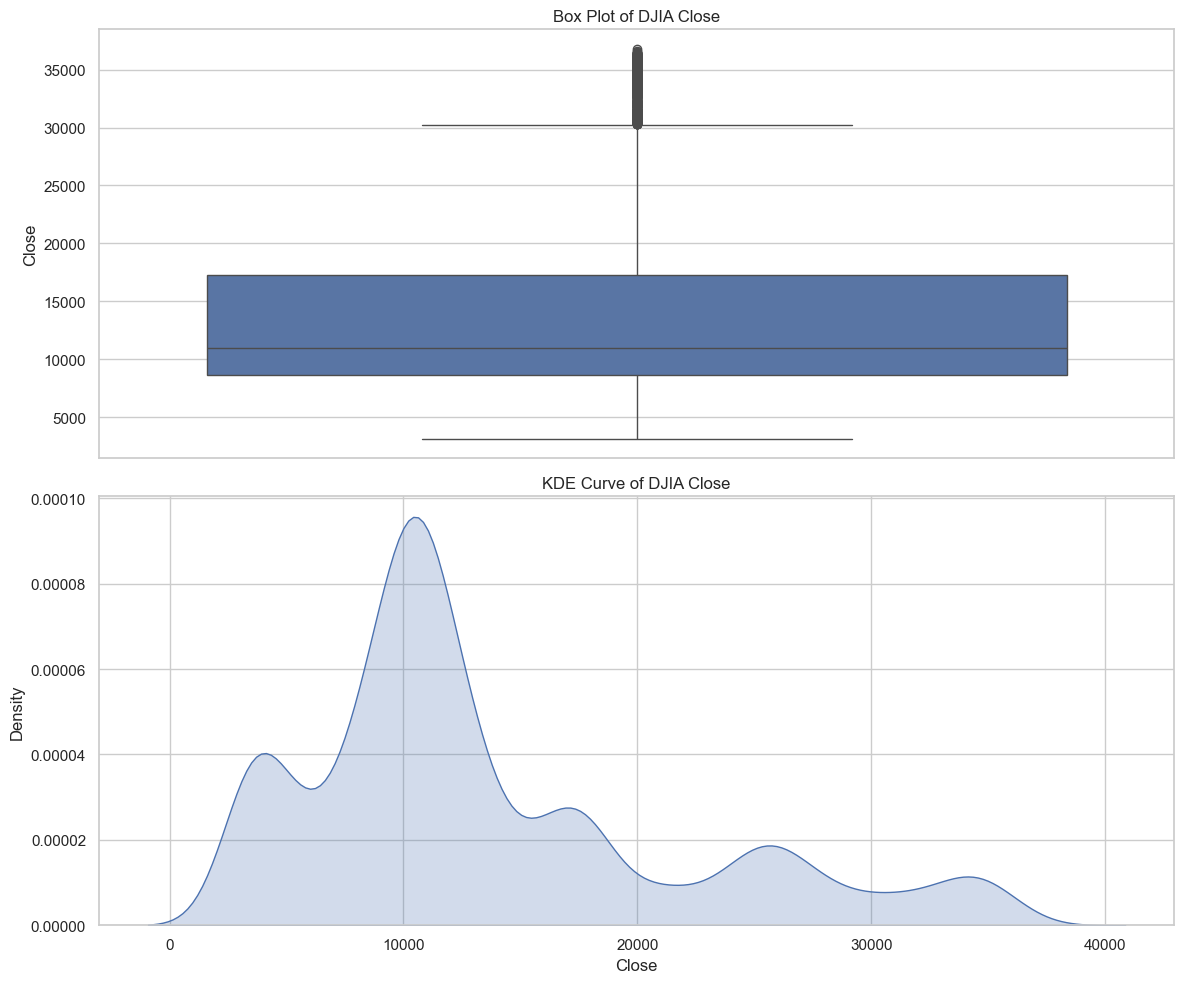

/var/folders/c_/rcydbtw12dz7bdcbj5s8j8r00000gn/T/ipykernel_4210/1740336208.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[column], ax=axes[1], shade=True)


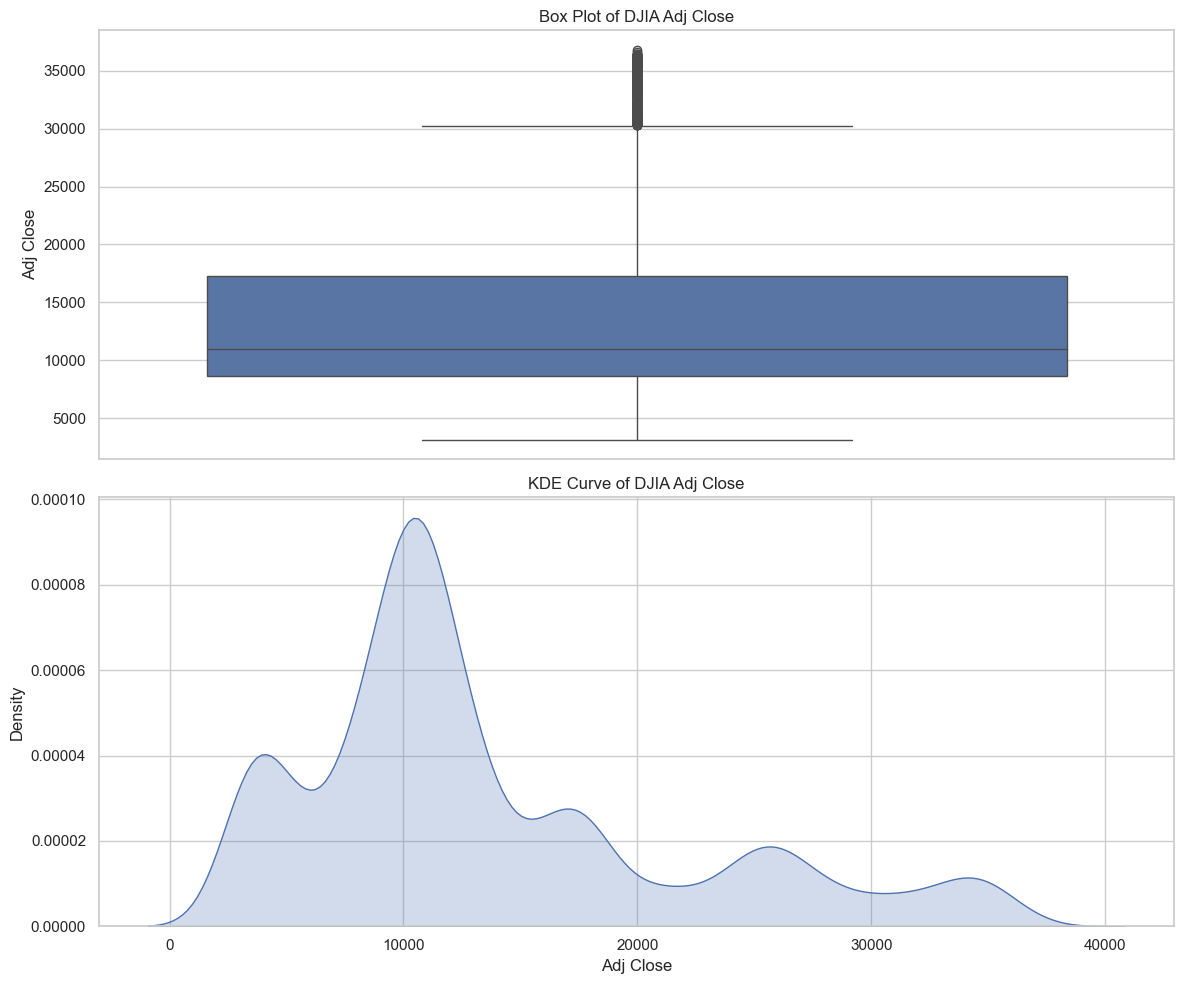

/var/folders/c_/rcydbtw12dz7bdcbj5s8j8r00000gn/T/ipykernel_4210/1740336208.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df[column], ax=axes[1], shade=True)


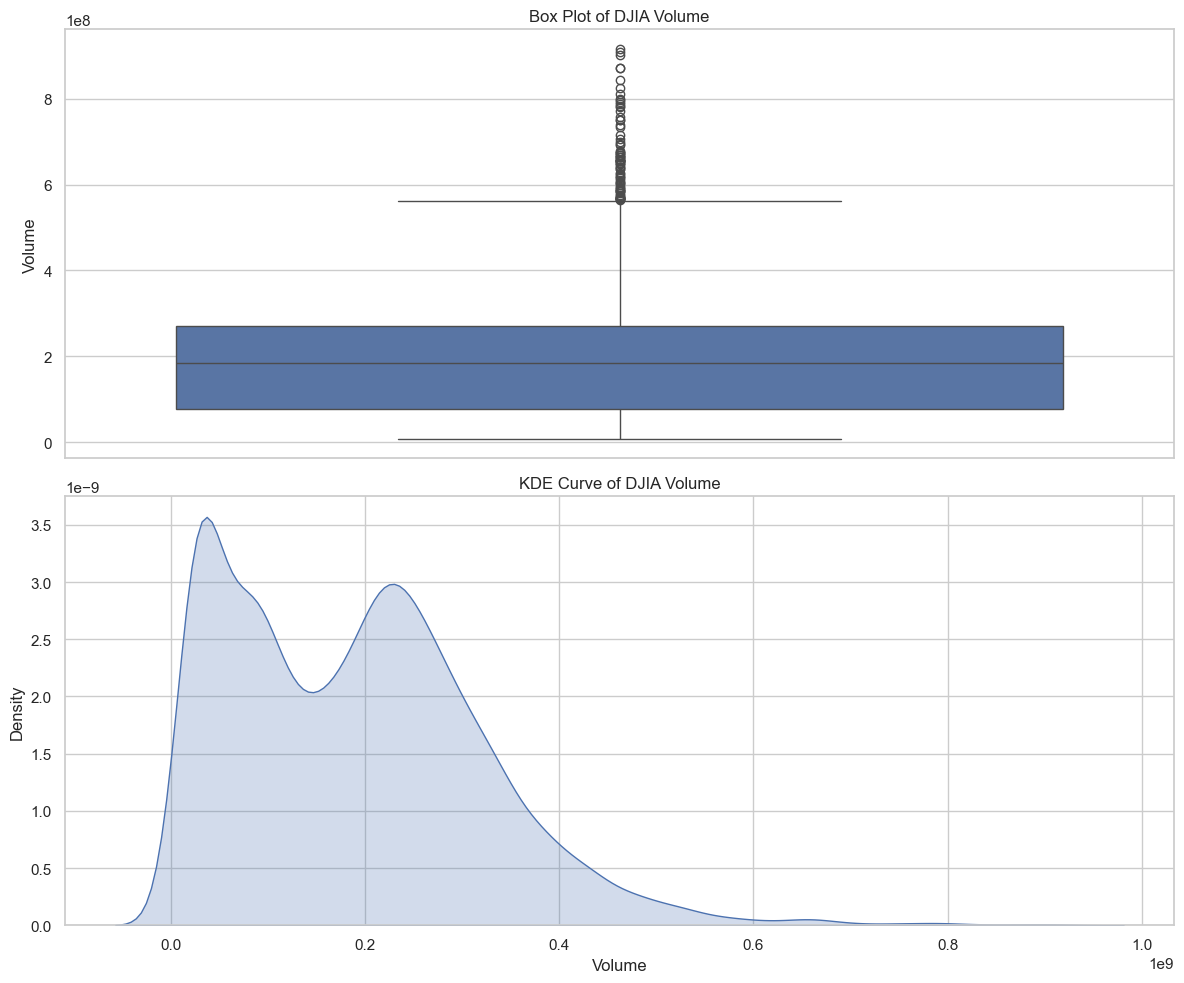

In [20]:
def perform_eda(df, start_date, end_date):    
    # Create EDA for each feature
    for column in df.columns:
        # Create a figure and axes
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))
        
        # Box plot
        sns.boxplot(data=df[column], ax=axes[0])
        axes[0].set_title(f'Box Plot of DJIA {column}')
        
        # KDE curve
        sns.kdeplot(data=df[column], ax=axes[1], shade=True)
        axes[1].set_title(f'KDE Curve of DJIA {column}')
        
        # Display the plots
        plt.tight_layout()
        plt.show()

# Example usage
perform_eda(df, "1980-01-01", "2023-01-01")

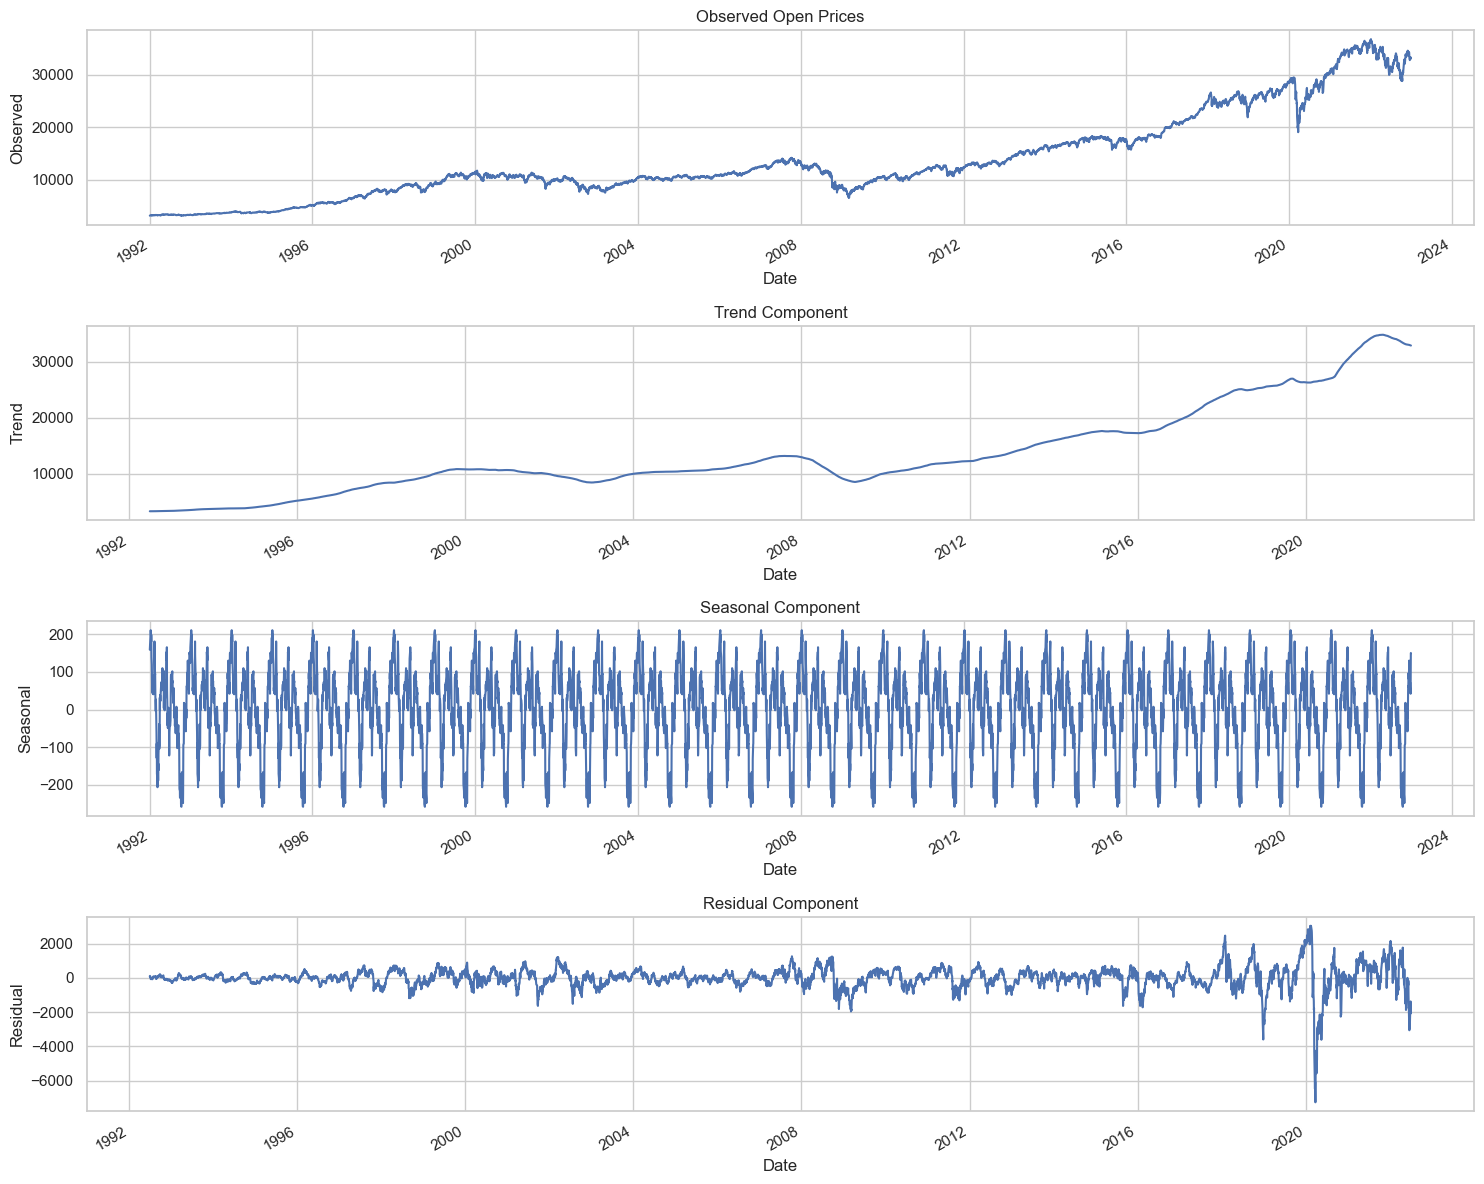

In [23]:
# Ensure the data is sorted by date
df_time = df.sort_index()

# Perform time series decomposition on the open price
open_price = df_time['Open']
result = seasonal_decompose(open_price, model='additive', period=252)  # Assuming 252 trading days in a year

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Observed
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Observed Open Prices')

# Trend
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
ax2.set_title('Trend Component')

# Seasonal
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
ax3.set_title('Seasonal Component')

# Residual
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_title('Residual Component')

plt.tight_layout()
plt.show()

In [39]:
class TradingEnv(gym.Env):
    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.df = df
        self.current_step = 0
        self.initial_balance = 10000
        self.balance = self.initial_balance
        self.asset = 0
        self.net_worth = self.initial_balance

        # Define the action space (0: hold, 1: buy, 2: sell)
        self.action_space = spaces.Discrete(3)

        # Define the observation space
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(len(df.columns) + 3,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.asset = 0
        self.net_worth = self.initial_balance
        return self._next_observation()

    def _next_observation(self):
        # Get the market data for the current step
        market_data = self.df.iloc[self.current_step].values

        # Concatenate market data with account information
        obs = np.concatenate((market_data, [self.balance, self.asset, self.net_worth]))

        return obs

    def step(self, action):
        current_price = self.df.iloc[self.current_step]['Close']
        self.current_step += 1

        if action == 1:  # Buy
            self.asset += self.balance / current_price
            self.balance = 0
        elif action == 2:  # Sell
            self.balance += self.asset * current_price
            self.asset = 0

        self.net_worth = self.balance + self.asset * current_price
        reward = self.net_worth - self.initial_balance

        done = self.current_step >= len(self.df) - 1

        obs = self._next_observation()
        return obs, reward, done, {}

    def render(self, mode='human'):
        print(f'Step: {self.current_step}')
        print(f'Balance: {self.balance}')
        print(f'Asset: {self.asset}')
        print(f'Net Worth: {self.net_worth}')




# Q-Learning Agent
class QLearningAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = np.zeros((state_size, action_size))
        self.learning_rate = 0.1
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action] * (1 - done)
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error

        if done:
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

In [37]:
# Create the environment
env = TradingEnv(df)

# Reset the environment
state = env.reset()

# Take a sample step
action = env.action_space.sample()  # Random action (for illustration)
next_state, reward, done, _ = env.step(action)

# Render the environment
env.render()

Step: 1
Balance: 10000
Asset: 0
Net Worth: 10000.0


In [40]:
# Create the environment
env = TradingEnv(df)

# Initialize the Q-Learning agent
state_size = len(df.columns) + 3
action_size = env.action_space.n
agent = QLearningAgent(state_size, action_size)

# Train the agent
episodes = 1000
for e in range(episodes):
    state = env.reset()
    state = np.argmax(state)  # Convert state to discrete index
    done = False
    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.argmax(next_state)  # Convert next_state to discrete index
        agent.learn(state, action, reward, next_state, done)
        state = next_state
    if (e + 1) % 100 == 0:
        print(f"Episode {e + 1}/{episodes}")

# Render the final environment
env.render()

Episode 100/1000
Episode 200/1000
Episode 300/1000
Episode 400/1000
Episode 500/1000
Episode 600/1000
Episode 700/1000
Episode 800/1000
Episode 900/1000
Episode 1000/1000
Step: 7808
Balance: 0
Asset: 2.3914794955557586
Net Worth: 79446.8638943021


In [43]:
# Create the environment
env = TradingEnv(df)

# Wrap the environment
env = DummyVecEnv([lambda: env])

# Normalize the environment
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

# Initialize PPO model
model = PPO('MlpPolicy', env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)

# Save the model
model.save("ppo_trading_model")

# Load the model
model = PPO.load("ppo_trading_model")

# Test the model
obs = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
        break

# Save and close the environment
env.save("ppo_trading_env")
env.close()

ImportError: Missing shimmy installation. You provided an OpenAI Gym environment. Stable-Baselines3 (SB3) has transitioned to using Gymnasium internally. In order to use OpenAI Gym environments with SB3, you need to install shimmy (`pip install 'shimmy>=0.2.1'`).

In [ ]:
# Create the environment
env = TradingEnv(df)

# Wrap the environment
env = DummyVecEnv([lambda: env])

# Normalize the environment
env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

# Initialize DDPG model
n_actions = env.action_space.shape[-1]
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.5) * np.ones(n_actions))
model = DDPG('MlpPolicy', env, action_noise=action_noise, verbose=1)

# Train the model
model.learn(total_timesteps=10000)

# Save the model
model.save("ddpg_trading_model")

# Load the model
model = DDPG.load("ddpg_trading_model")

# Test the model
obs = env.reset()
for _ in range(1000):
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    env.render()
    if done:
        break

# Save and close the environment
env.save("ddpg_trading_env")
env.close()